# Training of a U-Net for image dealiasing

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from keras.datasets import cifar10
import seaborn as sns
from skimage import color
import pandas as pd

from fastmri_recon.data.test_generators import CifarGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.utils import keras_ssim, keras_psnr
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse
from fastmri_recon.helpers.fourier import fft
from fastmri_recon.helpers.utils import gen_mask
from fastmri_recon.helpers.reconstruction import zero_filled_recon
from numpy.random import seed
from tensorflow import set_random_seed

Using TensorFlow backend.


In [4]:
# parameter initialization
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

im_size = 32
AF = 2

In [5]:
def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [6]:
# define generator
g = generator_model()
g_opt = Adam(lr=1e-3, clipnorm=1.)
g.compile(optimizer=g_opt, loss='mse', metrics=[keras_psnr, keras_ssim])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=False):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    with sns.color_palette("PuBuGn_d"):
        for n, (image, title) in enumerate(zip(images, titles)):
            a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
            plt.imshow(image, )
            a.set_title(title)
    #plt.colorbar()
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save:
        plt.savefig("/Users/WorkAccount/Desktop/generator_outputs")
    plt.show()

In [8]:
# load data from cifar10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = color.rgb2gray(x_train)
x_test = color.rgb2gray(x_test)

In [9]:
# image generator creation
image_test = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()
image_gen = CifarGenerator(AF, im_size, x_train, max_size=50000).flow_z_filled_images()

In [16]:
# define checkpoint path
run_id = f'gen_af{AF}_{int(time.time())}'
chkpt_path = f'../checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

gen_af2_1575905185


In [17]:
print(chkpt_path)

../checkpoints/gen_af2_1575905185-{epoch:02d}.hdf5


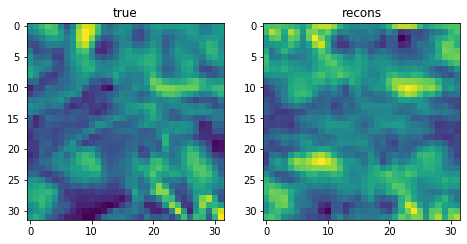

PSNR :  5.941197806429762
MSE :  0.18610851096364117
NMSE :  0.9926710588461772


In [18]:
# plot images from generator
im = next(image_gen)
iim = next(image_gen)
show_images([np.squeeze(im[1]), np.squeeze(im[0])],
            titles = ["true", "recons"])

print("PSNR : ", psnr(np.squeeze(im[1]), np.squeeze(im[0])))
print("MSE : ", mse(im[1], im[0]))
print("NMSE : ", nmse(im[1], im[0]))

In [19]:
# callback definition
tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")
chkpt_cback = ModelCheckpoint(chkpt_path, period=10)

In [20]:
%%time
# train generator
h = g.fit_generator(image_gen,
                steps_per_epoch=100,
                verbose=0,
                epochs=10,
                callbacks=[tqdm_cb, chkpt_cback],
                validation_data=image_test,
                validation_steps=100
                )


CPU times: user 1min 37s, sys: 37.5 s, total: 2min 15s
Wall time: 1min 10s


In [22]:
results = g.evaluate_generator(image_test, steps=50, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', results)

50/50 [==============================] - 0s 9ms/step
test loss, psnr,ssim: [0.018884366378188133, 13.816872596740723, 0.44293907284736633]


In [27]:
def show_prediction(g, im_true, im_alias):
    im_pred =  g.predict(im_alias)
    im_true = np.squeeze(im_true)
    im_alias = np.squeeze(im_alias)
    im_pred = np.squeeze(im_pred)
    show_images([im_true, im_alias, im_pred], titles=["true", "aliased", "predicted"])
    print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
    print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
    print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))
    

In [24]:
image_test = CifarGenerator(AF, im_size, x_test, max_size=50000).flow_z_filled_images()

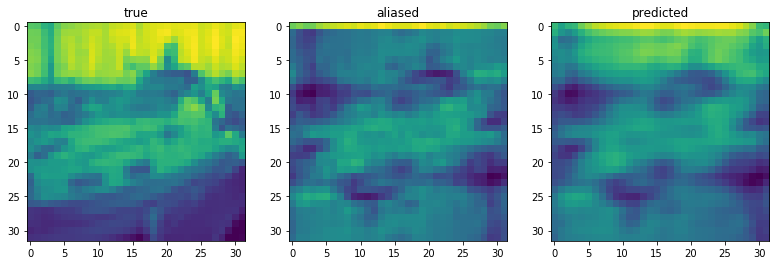

PSNR aliased image:  4.5252489587512015 
PSNR predicted image: 14.388334870896749

MSE aliased image:  0.3267727185141949 
MSE predicted image: 0.03372385395986305

NMSE aliased image:  0.9934042113903306 
NMSE predicted image: 0.10252207926159888


In [28]:
# show predictions from network
im = next(image_test)
show_prediction(g, im[1], im[0])

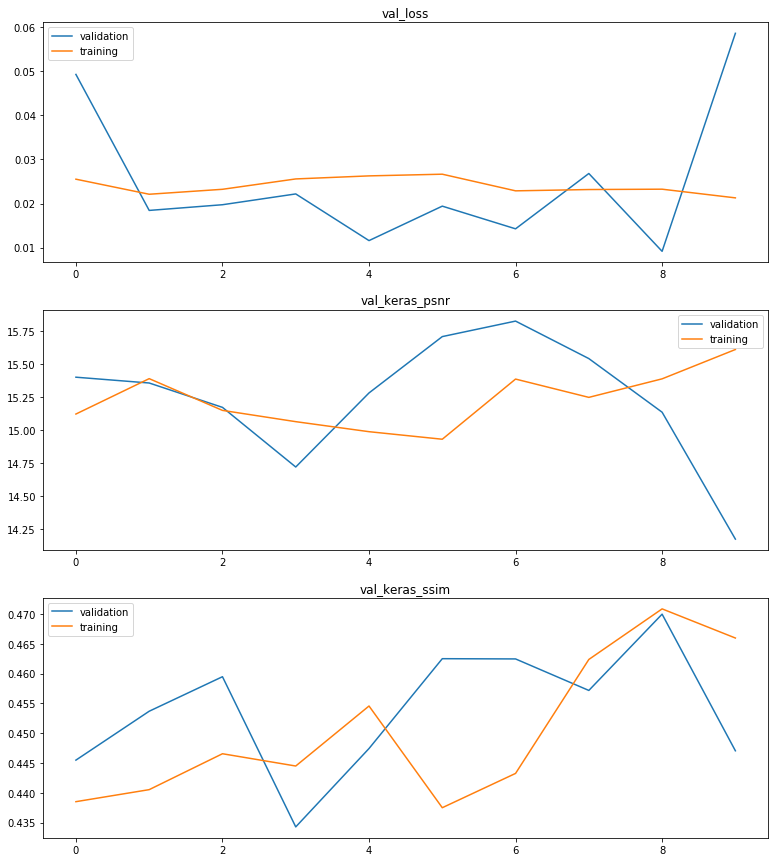

In [31]:
# plot training history
val = True
fig, axs = plt.subplots(2,2,figsize=(13,15))
images = [h.history[l] for l in h.history]
titles = [l for l in h.history]
if val==True:
    for i in range(len(titles)//2):
        plt.subplot(3, 1, i+1)
        plt.plot(images[i], label='validation')
        plt.plot(images[i+3], label='training')
        plt.title(titles[i])
        plt.legend()
else:
    for i in range(len(titles)):
        plt.subplot(3, 1, i+1)
        plt.plot(images[i])
        plt.title(titles[i])
        plt.legend()
    plt.show()
plt.show()

In [ ]:
# save training history
hist_df = pd.DataFrame(hist.history) 
hist_json_file = path + 'training_history2.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

![](http://)![](http://)![](http://)<a href='../checkpoints/replace_here.hdf5'> Download model </a>